In [84]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

!pip install imageio
!pip install git+https://github.com/tensorflow/docs
from tensorflow.keras import layers
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython import display
BUFFER_SIZE = 60000
BATCH_SIZE = 32

  Cloning https://github.com/tensorflow/docs to c:\users\iamva\appdata\local\temp\pip-req-build-hdv_gpzi


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\iamva\AppData\Local\Temp\pip-req-build-hdv_gpzi'
  fatal: unable to access 'https://github.com/tensorflow/docs/': SSL certificate problem: self signed certificate in certificate chain
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\iamva\AppData\Local\Temp\pip-req-build-hdv_gpzi' did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\iamva\AppData\Local\Temp\pip-req-build-hdv_gpzi' did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [85]:
classes = ['Agriculture', 'Beach', 'Forest',
           'Residential', 'River', 'Seawater']
train_datagen = ImageDataGenerator(
    rescale=1.0/127.5 - 1,  # Adjust rescaling to map pixel values to [-1, 1]
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2]
)

train_dir = '../Training'
img_height, img_width = 128, 128
num_classes = 6
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    class_mode='categorical'
)
print(train_set.class_indices)

Found 50 images belonging to 1 classes.


{'Train': 0}


In [86]:
test_datagen = ImageDataGenerator(
    rescale=1.0/127 -1
)
test_dir = '../Validation'
img_height, img_width = 128, 128
num_classes = 6
test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    class_mode='categorical'
)
print(test_set.class_indices)

Found 365 images belonging to 6 classes.
{'Agriculture': 0, 'Beach': 1, 'Forest': 2, 'Residential': 3, 'River': 4, 'Seawater': 5}


In [87]:
def make_generator_model():
    model = tf.keras.Sequential()
    # We start with a dense layer that will be reshaped to a suitable feature map
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 512)))  # Reshape to a 8x8x512 feature map
    # Scale up to 16x16x256
    model.add(layers.Conv2DTranspose(
        256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Scale up to 32x32x128
    model.add(layers.Conv2DTranspose(
        128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Scale up to 64x64x64
    model.add(layers.Conv2DTranspose(
        64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Scale up to 128x128x3
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2),
              padding='same', use_bias=False, activation='tanh'))

    return model

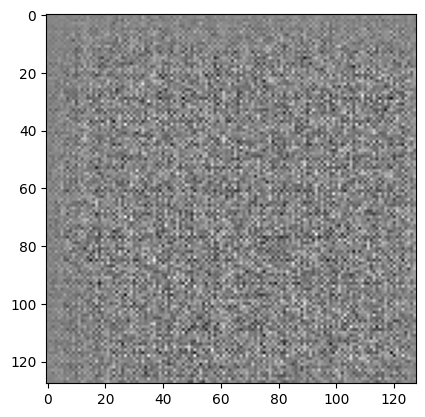

In [88]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [89]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    # Input shape adjusted for 128x128x3 images
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2),
              padding='same', input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Additional downsampling to 32x32x128
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Downsample to 16x16x256
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten the output and add the final dense layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [90]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00026849]], shape=(1, 1), dtype=float32)


In [91]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [92]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [93]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [94]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))

In [95]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

# def train(dataset, epochs, generator, discriminator, checkpoint, checkpoint_prefix, seed):
#     for epoch in range(epochs):
#         start = time.time()
#         total_accuracy = 0
#         num_batches = 0

#         for image_batch, labels_batch in dataset:  # Unpack the images and labels
#             # Only pass the images to the train_step function
#             # Assuming train_step adjusted to accept labels if needed
#             loss, accuracy = train_step(image_batch, discriminator)
#             total_accuracy += accuracy
#             num_batches += 1

#         avg_accuracy = total_accuracy / num_batches

#         # Produce images for the GIF as you go
#         display.clear_output(wait=True)
#         generate_and_save_images(generator, epoch + 1, seed)

#         # Save the model every 15 epochs
#         if (epoch + 1) % 15 == 0:
#             checkpoint.save(file_prefix=checkpoint_prefix)

#         print('Time for epoch {} is {} sec'.format(
#             epoch + 1, time.time() - start))
#         print('Discriminator accuracy for epoch {}: {:.2f}%'.format(
#             epoch + 1, avg_accuracy * 100))

#     # Generate after the final epoch
#     display.clear_output(wait=True)
#     generate_and_save_images(generator, epochs, seed)

In [96]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [98]:
# train(train_set, EPOCHS)
train(train_set, EPOCHS)

ValueError: in user code:

    File "C:\Users\iamva\AppData\Local\Temp\ipykernel_37692\3677487252.py", line 10, in train_step  *
        real_output = discriminator(images, training=True)
    File "c:\Users\iamva\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\iamva\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "sequential_9" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'images:0' shape=(32, 128, 128, 3) dtype=float32>, <tf.Tensor 'images_1:0' shape=(32, 1) dtype=float32>]
